### Classification audio files with cnn1d

In [59]:
%matplotlib inline  
import gc
import pickle
import random
from multiprocessing import Pool
from scipy.io.wavfile import read, write
import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
import os
from numpy import random
import librosa
import numpy as np
import glob
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pydub
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [60]:
input_length = 16000*2

batch_size = 32

def audio_norm(data):

    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] 
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        
        max_offset = input_length - len(data)
        
        offset = np.random.randint(max_offset)
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = audio_norm(data)
    return data

In [61]:
train_files = glob.glob("audio/*.wav")
#test_files = glob.glob("../input/audio_test/*.wav")
train_labels = pd.read_csv("Small.csv")
data = train_labels

In [62]:
train_labels=train_labels.drop('Unnamed: 0',axis=1)

In [63]:
print(data.groupby('Class'))

In [64]:
train_labels.head()

,path,size,Class
0,audio/background_0045_time_stretch_7.wav,254502,background
1,audio/knocking_door_0002.wav,254494,knocking_door
2,audio/ring_0433.wav,254464,ring
3,audio/background_0057_time_stretch_0.wav,254366,background
4,audio/background_0012_time_stretch_13.wav,254270,background


In [65]:
Classes = train_labels['Class'].unique()

In [66]:
train_labels.head()
paths = train_labels['path']

In [67]:
paths

0          audio/background_0045_time_stretch_7.wav
1                      audio/knocking_door_0002.wav
2                               audio/ring_0433.wav
3          audio/background_0057_time_stretch_0.wav
4         audio/background_0012_time_stretch_13.wav
5          audio/background_0052_time_stretch_0.wav
6          audio/background_0031_time_stretch_9.wav
7          audio/background_0011_time_stretch_9.wav
8                audio/bags_0034_time_stretch_3.wav
9          audio/background_0041_time_stretch_7.wav
10             audio/t_door_0074_time_stretch_2.wav
11               audio/door_0032_time_stretch_7.wav
12         audio/background_0058_time_stretch_8.wav
13               audio/bags_0034_time_stretch_0.wav
14                              audio/ring_0644.wav
15                          audio/keyboard_0003.wav
16                            audio/speech_0028.wav
17                            audio/speech_0041.wav
18                        audio/t_keyboard_0047.wav
19          

In [68]:
cnt_classes={'background': 1126,
 'bags': 2362,
 'door': 5778,
 'keyboard': 7003,
 'knocking_door': 8659,
 'ring': 9372,
 'speech': 9648,
 'tool': 11307}

In [69]:
train_labels['Class'][1658]

'knocking_door'

In [73]:
train_labels.head()
train_labels.columns=['Name','size','Class']

In [74]:
train_labels.groupby(['Class'][0])

In [75]:
file_to_label = {"audio/" + k:v for k,v in zip(train_labels.Name.values, train_labels.Class.values)}

In [76]:
train_labels['Class'][0]

'background'

In [77]:
sizes=[] 
for i in range(len(paths)):
    sizes.append(os.path.getsize(paths[i]))

In [78]:
d = {'path':paths, 'size':sizes,'Class':train_labels['Class']}
df=pd.DataFrame(data=d, columns=['path','size','Class'])

In [79]:
df.head()

,path,size,Class
0,audio/background_0045_time_stretch_7.wav,254502,background
1,audio/knocking_door_0002.wav,254494,knocking_door
2,audio/ring_0433.wav,254464,ring
3,audio/background_0057_time_stretch_0.wav,254366,background
4,audio/background_0012_time_stretch_13.wav,254270,background


In [80]:
df = df.sort_values(by='size',ascending=False)
df = df.reset_index()

In [81]:
df.head(100)

,index,path,size,Class
0,0,audio/background_0045_time_stretch_7.wav,254502,background
1,1,audio/knocking_door_0002.wav,254494,knocking_door
2,2,audio/ring_0433.wav,254464,ring
3,3,audio/background_0057_time_stretch_0.wav,254366,background
4,4,audio/background_0012_time_stretch_13.wav,254270,background
5,5,audio/background_0052_time_stretch_0.wav,254262,background
6,6,audio/background_0031_time_stretch_9.wav,254184,background
7,7,audio/background_0011_time_stretch_9.wav,254066,background
8,8,audio/bags_0034_time_stretch_3.wav,253810,bags
9,9,audio/background_0041_time_stretch_7.wav,253806,background


In [82]:
df=df.drop('index',axis=1)

In [83]:
train_labels['Class'][1658]

'knocking_door'

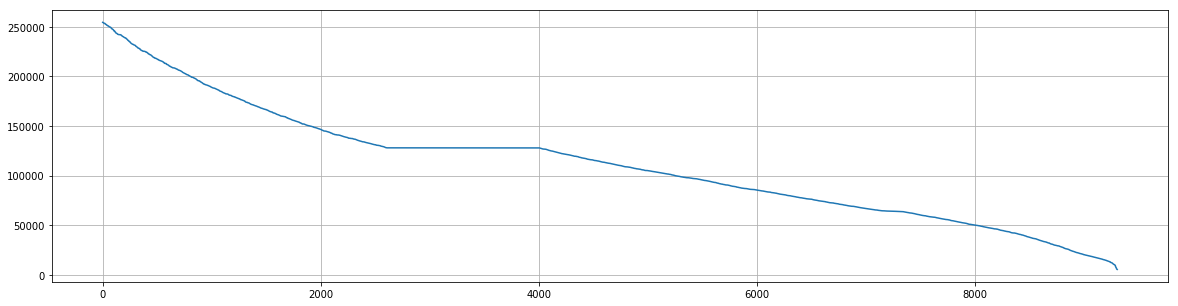

In [91]:
a = []
for i in range(len(df)):
    a.append(i)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(a,df['size'])
plt.show()

In [95]:
df_1=df[::2000]
df_2=df[2001:5000]
df_3=df[5001::]

In [96]:
df_1.to_csv('small.txt')
df_2.to_csv('mid.txt')
df_3.to_csv('large.txt')

In [97]:
train_files[1]

'audio/d_0014_time_stretch_3.wav'

## concate files

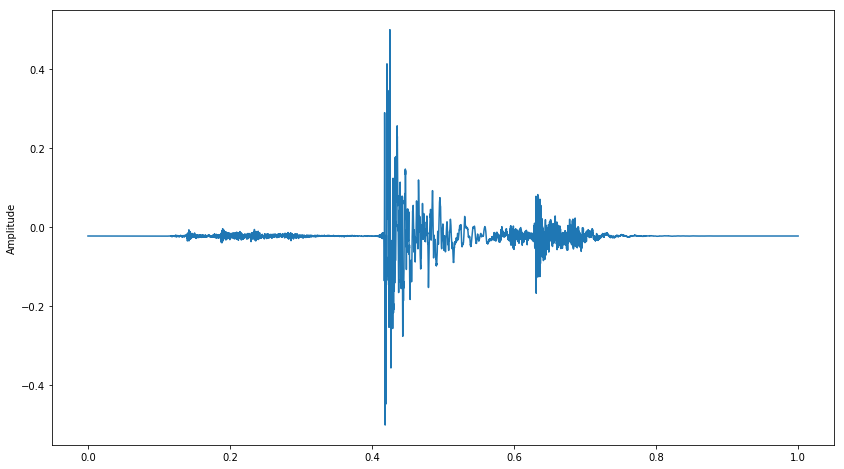

In [99]:
data_base = load_audio_file(train_files[1])
fig = plt.figure(figsize=(14, 8))
#plt.title('Raw wave : %s ' % (file_to_label[train_files[0]]))
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, input_length), data_base)
plt.show()

In [100]:
list_labels = sorted(list(set(train_labels.Class.values)))

In [101]:
list_labels

['background',
 'bags',
 'door',
 'keyboard',
 'knocking_door',
 'ring',
 'speech',
 'tool']

In [102]:
label_to_int = {k:v for v,k in enumerate(list_labels)}

In [103]:
int_to_label = {v:k for k,v in label_to_int.items()}

In [104]:
file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}

In [105]:
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=16)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.0001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [106]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [107]:
def train_generator(list_files, batch_size=batch_size):
    while True:
        shuffle(list_files)
        for batch_files in chunker(list_files, size=batch_size):
            batch_data = [load_audio_file(fpath) for fpath in batch_files]
            batch_data = np.array(batch_data)[:,:,np.newaxis]
            batch_labels = [file_to_int[fpath] for fpath in batch_files]
            batch_labels = np.array(batch_labels)
            #print(batch_data)
            print(batch_data.shape)
            print('++++++++++++++++++++++++++++++++++++')
            print(batch_labels)
            yield batch_data, batch_labels
            

In [108]:
tr_files, val_files = train_test_split(train_files, test_size=0.1)

In [109]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [111]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32000, 1)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 31992, 16)         160       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 31984, 16)         2320      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1999, 16)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1999, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1997, 32)          1568      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1995, 32)          3104      
__________

In [112]:
batch_size = 32

In [113]:
model.save_weights("cnn15.h5")

In [ ]:
model.fit_generator(train_generator(tr_files), steps_per_epoch=len(tr_files)//batch_size, epochs=5,
                   use_multiprocessing=True, workers=4, max_queue_size=10)

/home/nestyme/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
(32, 32000, 1)
++++++++++++++++++++++++++++++++++++
[2 2 5 4 5 4 4 2 5 2 1 0 2 2 4 2 6 7 4 1 3 2 6 0 4 1 0 4 6 2 3 7]
(32, 32000, 1)
++++++++++++++++++++++++++++++++++++
[7 4 7 6 7 0 3 1 2 2 7 0 4 2 2 7 4 7 0 2 2 2 3 3 4 7 2 2 2 3 3 3]
(32, 32000, 1)
++++++++++++++++++++++++++++++++++++
[2 3 7 4 1 5 2 3 2 2 7 7 2 4 3 2 3 4 2 3 1 2 4 7 2 2 4 2 2 0 2 2]
(32, 32000, 1)
++++++++++++++++++++++++++++++++++++
[2 2 2 7 3 4 4 4 2 4 7 0 3 0 0 0 7 0 7 7 1 4 3 3 1 1 2 1 4 4 2 7]


In [ ]:
list_preds = []


In [ ]:
for batch_files in tqdm(chunker(val_files, size=batch_size), total=len(val_files)//batch_size ):
    batch_data = [load_audio_file(fpath) for fpath in batch_files]
    batch_data = np.array(batch_data)[:,:,np.newaxis]
    preds = model.predict(batch_data).tolist()
    list_preds += preds            

In [ ]:
array_preds = np.array(list_preds)

In [ ]:
len(list_preds)

In [ ]:
list_preds

In [ ]:
list_labels = np.array(list_labels)

In [ ]:
len(list_labels)

In [ ]:
top_1 = list_labels[np.argsort(-array_preds, axis=1)[:, :1]]
pred_labels = [label_to_int[' '.join(list(x))] for x in top_1]
true_labels = [label_to_int[file_to_label[x]] for x in val_files]

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report

In [ ]:
list_labels

In [ ]:
print(classification_report(true_labels, pred_labels, target_names=list(list_labels)))

In [ ]:
f1_score(pred_labels, true_labels, average='macro')

In [ ]:
true_labels[:10]

In [ ]:
df = pd.DataFrame(test_files, columns=["fname"])
df['label'] = pred_labels

In [ ]:
df['fname'] = df.fname.apply(lambda x: x.split("/")[-1])